# Simple neural network

Tutorial:
https://andrew.carterlunn.co.uk/programming/2018/02/20/beating-the-bookmakers-with-tensorflow.html

In [ ]:
# runs the neural network training, and the betting analysis. Output file is training-log.csv
#%run predict.py

In [124]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

import tensorflow as tf
import dataset
import betting
import csv

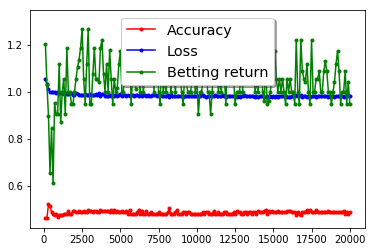

In [3]:
x,a, b, c = np.loadtxt('training-log.csv', delimiter=',', unpack=True)

# red dashes, blue squares and green triangles
plt.plot(x, a, '.r-', x, b, '.b-', x, c, '.g-')

plt.legend(('Accuracy', 'Loss','Betting return'), loc='upper center', shadow=True, fontsize='x-large')

plt.show()

## Restore model from checkpoint

In [4]:
TRAINING_SET_FRACTION = 0.95

data = dataset.Dataset('data/book.csv')

train_results_len = int(TRAINING_SET_FRACTION * len(data.processed_results))
train_results = data.processed_results[:train_results_len]
test_results = data.processed_results[train_results_len:]

def map_results(results):
    features = {}

    for result in results:
        for key in result.keys():
            if key not in features:
                features[key] = []

            features[key].append(result[key])

    for key in features.keys():
        features[key] = np.array(features[key])

    return features, features['result']

train_features, train_labels = map_results(train_results)
test_features, test_labels = map_results(test_results)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=train_features,
    y=train_labels,
    batch_size=500,
    num_epochs=None,
    shuffle=True
)

test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=test_features,
    y=test_labels,
    num_epochs=1,
    shuffle=False
)

feature_columns = []

for mode in ['home', 'away']:
    feature_columns = feature_columns + [
        tf.feature_column.numeric_column(key='{}-wins'.format(mode)),
        tf.feature_column.numeric_column(key='{}-draws'.format(mode)),
        tf.feature_column.numeric_column(key='{}-losses'.format(mode)),
        tf.feature_column.numeric_column(key='{}-goals'.format(mode)),
        tf.feature_column.numeric_column(key='{}-opposition-goals'.format(mode)),
        tf.feature_column.numeric_column(key='{}-shots'.format(mode)),
        tf.feature_column.numeric_column(key='{}-shots-on-target'.format(mode)),
        tf.feature_column.numeric_column(key='{}-opposition-shots'.format(mode)),
        tf.feature_column.numeric_column(key='{}-opposition-shots-on-target'.format(mode)),
    ]

In [5]:
model = tf.estimator.DNNClassifier(
    model_dir='model/',
    hidden_units=[10],
    feature_columns=feature_columns,
    n_classes=3,
    label_vocabulary=['H', 'D', 'A'],
    optimizer=tf.train.ProximalAdagradOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=0.001
    ))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000206E1C6C6A0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
# What is the latest checkpoint?
model.latest_checkpoint()

'model/model.ckpt-20000'

In [7]:
evaluation_result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-04-16:04:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-04-16:04:19
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.4883721, average_loss = 0.9819084, global_step = 20000, loss = 84.44412
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 20000: model/model.ckpt-20000


In [8]:
predictions = list(model.predict(input_fn=test_input_fn))
prediction_result = betting.test_betting_stategy(predictions, test_features, test_labels)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [10]:
evaluation_result

{'accuracy': 0.4883721,
 'average_loss': 0.9819084,
 'loss': 84.44412,
 'global_step': 20000}

In [11]:
train_features

{'result': array(['H', 'D', 'A', ..., 'H', 'A', 'A'], dtype='<U1'),
 'odds-home': array([ 1.17,  2.  ,  1.91, ...,  2.14,  2.04, 11.  ]),
 'odds-draw': array([6.5 , 3.3 , 3.4 , ..., 3.39, 3.6 , 6.5 ]),
 'odds-away': array([21.  ,  4.  ,  4.2 , ...,  3.79,  3.79,  1.28]),
 'home-wins': array([7, 4, 4, ..., 7, 4, 2]),
 'home-draws': array([2, 1, 2, ..., 2, 3, 4]),
 'home-losses': array([1, 5, 4, ..., 1, 3, 4]),
 'home-goals': array([22, 10, 10, ..., 24, 15,  8]),
 'home-opposition-goals': array([ 4, 15, 15, ...,  4, 22, 12]),
 'home-shots': array([178, 110, 120, ..., 146, 111,  96]),
 'home-shots-on-target': array([92, 64, 68, ..., 53, 32, 28]),
 'home-opposition-shots': array([ 92, 151, 130, ...,  93, 130, 140]),
 'home-opposition-shots-on-target': array([52, 83, 69, ..., 28, 50, 31]),
 'away-wins': array([3, 4, 2, ..., 7, 3, 9]),
 'away-draws': array([3, 0, 2, ..., 2, 2, 1]),
 'away-losses': array([4, 6, 6, ..., 1, 5, 0]),
 'away-goals': array([ 9, 14, 11, ..., 26, 11, 37]),
 'away-opp

In [12]:
train_labels

array(['H', 'D', 'A', ..., 'H', 'A', 'A'], dtype='<U1')

In [19]:
# model prediction
predictions[0]

{'logits': array([-16.091715, -16.79451 , -17.004255], dtype=float32),
 'probabilities': array([0.5272309 , 0.26108435, 0.21168476], dtype=float32),
 'class_ids': array([0], dtype=int64),
 'classes': array([b'H'], dtype=object)}

In [24]:
# result
test_features['result'][0]

'H'

In [23]:
test_features.keys()

dict_keys(['result', 'odds-home', 'odds-draw', 'odds-away', 'home-wins', 'home-draws', 'home-losses', 'home-goals', 'home-opposition-goals', 'home-shots', 'home-shots-on-target', 'home-opposition-shots', 'home-opposition-shots-on-target', 'away-wins', 'away-draws', 'away-losses', 'away-goals', 'away-opposition-goals', 'away-shots', 'away-shots-on-target', 'away-opposition-shots', 'away-opposition-shots-on-target'])

In [26]:
test_features['odds-home'][0]

2.14

In [27]:
1 / test_features['odds-home'][0]

0.4672897196261682

## Chi squared goodness of fit
https://math.stackexchange.com/questions/1422353/how-can-we-measure-the-accuracy-of-prediction-algorithm/1422431#1422431?newreg=c36a5b242a4c41aa8cba7f657c86bc6b

In [29]:
import numpy as np

# `numpy.random` uses its own PRNG.
np.random.seed(444)
np.set_printoptions(precision=3)

d = np.random.laplace(loc=15, scale=3, size=500)

(0.0, 60.0)

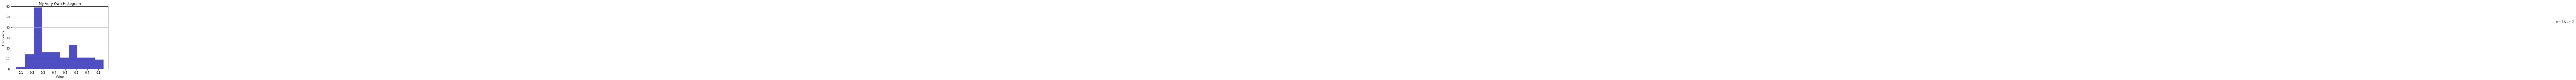

In [64]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=predictions_result_hist, bins=10, color='#0504aa',
                            alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


In [52]:
predictions_result = []

for i in range(0, len(predictions)):
    predictions_result = predictions_result + [{
        'result': test_features['result'][i],
        'p_home': predictions[i]['probabilities'][0],
        'p_draw': predictions[i]['probabilities'][1],
        'p_away': predictions[i]['probabilities'][2]
    }]

In [57]:
predictions_result_hist = []

for i in range(0, len(predictions)):
    if test_features['result'][i] == 'H':
        predictions_result_hist = predictions_result_hist + [
            predictions[i]['probabilities'][0]
        ]
    elif test_features['result'][i] == 'D':
        predictions_result_hist = predictions_result_hist + [
            predictions[i]['probabilities'][1]
        ]
    else:
        predictions_result_hist = predictions_result_hist + [
            predictions[i]['probabilities'][2]
        ]

In [58]:
predictions_result_hist

[0.5272309,
 0.2324312,
 0.4546906,
 0.12917992,
 0.14945297,
 0.27960566,
 0.36766142,
 0.57675695,
 0.31287688,
 0.2932102,
 0.65388644,
 0.77351904,
 0.38105795,
 0.3653556,
 0.46319318,
 0.28025815,
 0.59003395,
 0.6981579,
 0.5433696,
 0.53391963,
 0.44491234,
 0.27335045,
 0.27577314,
 0.4046051,
 0.26727855,
 0.62194586,
 0.21385697,
 0.28310084,
 0.17865108,
 0.5107828,
 0.59003395,
 0.48597157,
 0.278549,
 0.20062086,
 0.44423205,
 0.2801295,
 0.7434741,
 0.21338056,
 0.6849435,
 0.3411245,
 0.80987865,
 0.5611424,
 0.20321178,
 0.58512807,
 0.6365065,
 0.47970572,
 0.47347057,
 0.43800303,
 0.2631882,
 0.28369573,
 0.27021688,
 0.8474719,
 0.3506338,
 0.2817078,
 0.27672347,
 0.3014077,
 0.4440275,
 0.6254492,
 0.1611928,
 0.21524698,
 0.59003395,
 0.24877317,
 0.50137514,
 0.42989165,
 0.59003395,
 0.15409495,
 0.5506668,
 0.33863664,
 0.3201448,
 0.59003395,
 0.72192246,
 0.24877317,
 0.73183614,
 0.28323162,
 0.7203875,
 0.29120606,
 0.62150794,
 0.2547989,
 0.25963962,
 0

In [63]:
len(predictions)

172

### Brier score
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html

In [126]:
y_true = []
y_true_categorical = []
y_prob = []

for i in range(0, len(predictions)):
    y_true_categorical = y_true_categorical + ['H', 'D', 'A']
    y_prob = y_prob + [predictions[i]['probabilities'][0], predictions[i]['probabilities'][1], predictions[i]['probabilities'][2]]
    if test_features['result'][i] == 'H':
        y_true = y_true + [1, 0, 0]
    elif test_features['result'][i] == 'D':
        y_true = y_true + [0, 1, 0]
    else:
        y_true = y_true + [0, 0, 1]

In [128]:
arr_y_true = np.array(y_true)
arr_y_prob = np.array(y_prob)

brier_model = brier_score_loss(arr_y_true, arr_y_prob)
print(brier_model)

0.19533407516753873


In [90]:
# Brier score for only home wins

y_true_h = []
y_prob_h = []

for i in range(0, len(predictions)):
    if y_true_categorical[i] == 'H':
        y_true_h = y_true_h + [y_true[i]] 
        y_prob_h = y_prob_h + [y_prob[i]]
        
    
arr_y_true_h = np.array(y_true_h)
arr_y_prob_h = np.array(y_prob_h)

brier_score_loss(arr_y_true_h, arr_y_prob_h)

0.22706381418027663

### Brier score for bookies

In [118]:
y_true_book = []
y_true_categorical_book = []
y_prob_book = []

for i in range(0, len(predictions)):
    y_true_categorical_book = y_true_categorical_book + ['H', 'D', 'A']
    y_prob_book = y_prob_book + [1.0 / test_features['odds-home'][i], 1.0 / test_features['odds-draw'][i], 1.0 / test_features['odds-away'][i]]
    if test_features['result'][i] == 'H':
        y_true_book = y_true_book + [1, 0, 0]
    elif test_features['result'][i] == 'D':
        y_true_book = y_true_book + [0, 1, 0]
    else:
        y_true_book = y_true_book + [0, 0, 1]

In [119]:
arr_y_true_book = np.array(y_true_book)
arr_y_prob_book = np.array(y_prob_book)

brier_book = brier_score_loss(arr_y_true_book, arr_y_prob_book)
print(brier_book)

0.18721261611340528


In [102]:
# Brier score for only home wins
y_true_h_book = []
y_prob_h_book = []

for i in range(0, len(predictions)):
    if y_true_categorical_book[i] == 'H':
        y_true_h_book = y_true_h_book + [y_true_book[i]] 
        y_prob_h_book = y_prob_h_book + [y_prob_book[i]]
        
    
arr_y_true_h_book = np.array(y_true_h_book)
arr_y_prob_h_book = np.array(y_prob_h_book)

brier_h_book = brier_score_loss(arr_y_true_h_book, arr_y_prob_h_book)
print(brier_h_book)

0.18640809482329107


In [94]:
len(y_true_h_book)

58

### Calibration curve for bookie

In [120]:
fraction_of_positives, mean_predicted_value = \
            calibration_curve(arr_y_true_book, arr_y_prob_book, n_bins=10)

In [121]:
print(' fraction_of_positives = ', fraction_of_positives,'\n', 'mean_predicted_value = ',mean_predicted_value)

 fraction_of_positives =  [0.044 0.202 0.25  0.33  0.404 0.52  0.6   0.667 0.938 1.   ] 
 mean_predicted_value =  [0.073 0.158 0.262 0.336 0.453 0.549 0.634 0.772 0.855 0.926]


### Calibration curve

In [129]:
fraction_of_positives_model, mean_predicted_value_model = \
            calibration_curve(arr_y_true, arr_y_prob, n_bins=10)

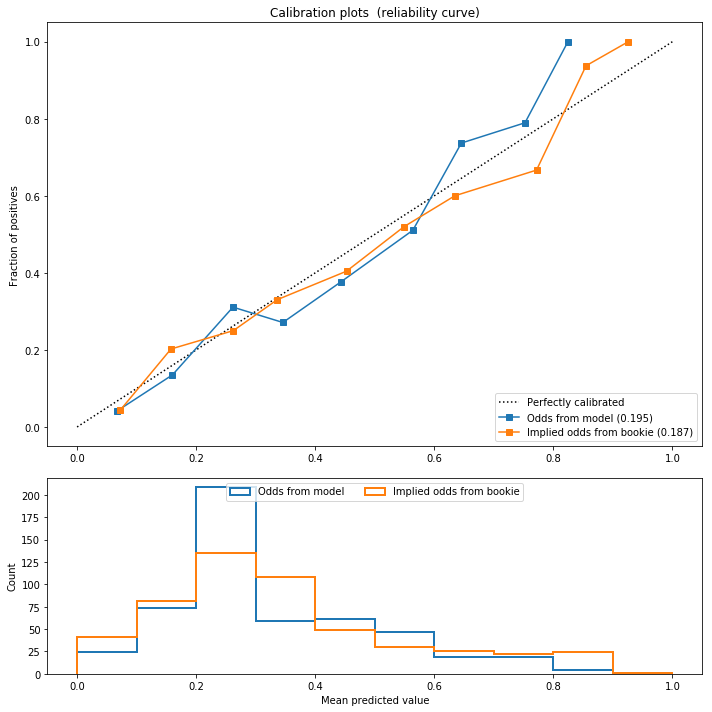

In [134]:
fig_index_model = 2
name_model = 'Odds from model'
clf_score_model = brier_model

fig = plt.figure(fig_index_model, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.plot(mean_predicted_value_model, fraction_of_positives_model, "s-",
         label="%s (%1.3f)" % (name_model, clf_score_model))

ax2.hist(arr_y_prob, range=(0, 1), bins=10, label=name_model,
         histtype="step", lw=2)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s (%1.3f)" % (name, clf_score))

ax2.hist(arr_y_prob_book, range=(0, 1), bins=10, label=name,
         histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [136]:
arr_y_true

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,

In [135]:
arr_y_prob

array([0.527, 0.261, 0.212, 0.232, 0.272, 0.496, 0.455, 0.275, 0.27 ,
       0.647, 0.224, 0.129, 0.615, 0.235, 0.149, 0.422, 0.28 , 0.299,
       0.349, 0.284, 0.368, 0.171, 0.253, 0.577, 0.313, 0.283, 0.404,
       0.293, 0.281, 0.426, 0.654, 0.221, 0.125, 0.774, 0.166, 0.061,
       0.381, 0.283, 0.336, 0.365, 0.283, 0.351, 0.463, 0.274, 0.263,
       0.416, 0.28 , 0.304, 0.161, 0.249, 0.59 , 0.698, 0.203, 0.099,
       0.543, 0.257, 0.2  , 0.202, 0.264, 0.534, 0.445, 0.277, 0.278,
       0.467, 0.273, 0.259, 0.452, 0.276, 0.272, 0.405, 0.281, 0.314,
       0.5  , 0.267, 0.233, 0.622, 0.233, 0.145, 0.524, 0.262, 0.214,
       0.376, 0.283, 0.341, 0.749, 0.179, 0.073, 0.22 , 0.269, 0.511,
       0.161, 0.249, 0.59 , 0.486, 0.27 , 0.244, 0.431, 0.279, 0.29 ,
       0.201, 0.263, 0.536, 0.276, 0.279, 0.444, 0.283, 0.28 , 0.437,
       0.743, 0.181, 0.075, 0.525, 0.262, 0.213, 0.685, 0.208, 0.107,
       0.341, 0.284, 0.375, 0.81 , 0.145, 0.045, 0.182, 0.257, 0.561,
       0.538, 0.258,

In [ ]:
#len(test_labels) =172
#len(predictions) = 172
#type(predictions) = list
#type(predictions[0]) = dic 

prob=predictions[0].get("probabilities")
prob

Expected=[0]*3
Actual=[0]*3

i=0

for game in predictions:
    probs=game.get("probabilities")
    Expected=Expected+probs
    ResulT=test_labels[i]
    if ResulT=="H":
        Actual[0]=Actual[0]+1
    elif ResulT=="A":
        Actual[1]=Actual[1]+1
    else:
        Actual[2]=Actual[2]+1
    i=i+1

chi_sqr=0
i=0
for expected in Expected:
    chi_sqr=chi_sqr+((expected-Actual[i])**2)/expected
    i=i+1
    
print(chi_sqr)
print("Expected")
print(Expected)
print("Actual")
print(Actual)